In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load preprocessed dataset
df = pd.read_csv("../data/processed/cleaned_fake_news.csv")

X = df["content"].fillna("")
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Load tokenizer (already saved earlier in preprocessing notebook)
tokenizer = joblib.load("../models/tokenizer.pkl")

MAX_LEN = 300
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")

print("Train shape:", X_train_pad.shape, "Test shape:", X_test_pad.shape)


Train shape: (35918, 300) Test shape: (8980, 300)


In [3]:
def create_lstm_model(units=128, dropout=0.3, lr=0.001, bidirectional=False):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, 
                        output_dim=100, 
                        input_length=MAX_LEN))
    
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(learning_rate=lr), 
        metrics=["accuracy"]
    )
    return model


In [4]:
experiments = [
    {"units": 64,  "dropout": 0.3, "lr": 0.001, "bidirectional": False},
    {"units": 128, "dropout": 0.3, "lr": 0.001, "bidirectional": False},
    {"units": 128, "dropout": 0.5, "lr": 0.001, "bidirectional": False},
    {"units": 128, "dropout": 0.3, "lr": 0.0005, "bidirectional": True},
    {"units": 256, "dropout": 0.3, "lr": 0.001, "bidirectional": True},
]

In [5]:
results = []

for i, params in enumerate(experiments):
    print(f"\n🚀 Training Experiment {i+1} with params: {params}")
    model = create_lstm_model(**params)
    
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_test_pad, y_test),
        epochs=3,
        batch_size=128,
        verbose=1
    )
    
    # Predictions
    y_pred_prob = model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype("int32")
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Experiment": i+1,
        "Params": params,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "_model_obj": model  # keep reference to trained model
    })


🚀 Training Experiment 1 with params: {'units': 64, 'dropout': 0.3, 'lr': 0.001, 'bidirectional': False}


C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 104s 352ms/step - accuracy: 0.6307 - loss: 0.5749 - val_accuracy: 0.6576 - val_loss: 0.4496
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 96s 341ms/step - accuracy: 0.9432 - loss: 0.1884 - val_accuracy: 0.9419 - val_loss: 0.1824
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 95s 338ms/step - accuracy: 0.9533 - loss: 0.1784 - val_accuracy: 0.9424 - val_loss: 0.2004
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step

🚀 Training Experiment 2 with params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'bidirectional': False}
Epoch 1/3


C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


281/281 ━━━━━━━━━━━━━━━━━━━━ 192s 667ms/step - accuracy: 0.8461 - loss: 0.3798 - val_accuracy: 0.9121 - val_loss: 0.2739
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 180s 641ms/step - accuracy: 0.8991 - loss: 0.3012 - val_accuracy: 0.6412 - val_loss: 0.5761
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 180s 642ms/step - accuracy: 0.7497 - loss: 0.4759 - val_accuracy: 0.9677 - val_loss: 0.1139
281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step

🚀 Training Experiment 3 with params: {'units': 128, 'dropout': 0.5, 'lr': 0.001, 'bidirectional': False}
Epoch 1/3


C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


281/281 ━━━━━━━━━━━━━━━━━━━━ 176s 615ms/step - accuracy: 0.7774 - loss: 0.4610 - val_accuracy: 0.9460 - val_loss: 0.2180
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 167s 597ms/step - accuracy: 0.9520 - loss: 0.1941 - val_accuracy: 0.9744 - val_loss: 0.1076
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 167s 595ms/step - accuracy: 0.9513 - loss: 0.1903 - val_accuracy: 0.6105 - val_loss: 0.6466
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step

🚀 Training Experiment 4 with params: {'units': 128, 'dropout': 0.3, 'lr': 0.0005, 'bidirectional': True}
Epoch 1/3


C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


281/281 ━━━━━━━━━━━━━━━━━━━━ 264s 922ms/step - accuracy: 0.9338 - loss: 0.1537 - val_accuracy: 0.9904 - val_loss: 0.0327
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 258s 917ms/step - accuracy: 0.9968 - loss: 0.0130 - val_accuracy: 0.9915 - val_loss: 0.0289
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 275s 981ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9962 - val_loss: 0.0156
281/281 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step

🚀 Training Experiment 5 with params: {'units': 256, 'dropout': 0.3, 'lr': 0.001, 'bidirectional': True}
Epoch 1/3


C:\Users\kausalya\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


281/281 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.9645 - loss: 0.0869 - val_accuracy: 0.9942 - val_loss: 0.0214
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.9982 - loss: 0.0070 - val_accuracy: 0.9957 - val_loss: 0.0150
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 710s 3s/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9924 - val_loss: 0.0326
281/281 ━━━━━━━━━━━━━━━━━━━━ 76s 267ms/step 


   Experiment                                             Params  Accuracy  \
3           4  {'units': 128, 'dropout': 0.3, 'lr': 0.0005, '...  0.996214   
4           5  {'units': 256, 'dropout': 0.3, 'lr': 0.001, 'b...  0.992428   
1           2  {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'b...  0.967706   
0           1  {'units': 64, 'dropout': 0.3, 'lr': 0.001, 'bi...  0.942428   
2           3  {'units': 128, 'dropout': 0.5, 'lr': 0.001, 'b...  0.610468   

   Precision    Recall        F1  
3   0.995325  0.997445  0.996384  
4   0.996780  0.988714  0.992730  
1   0.987605  0.950170  0.968526  
0   0.941102  0.949319  0.945192  
2   0.576579  0.960392  0.720562  


C:\Users\kausalya\AppData\Local\Temp\ipykernel_34584\2272127209.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Experiment", y="F1", palette="viridis")


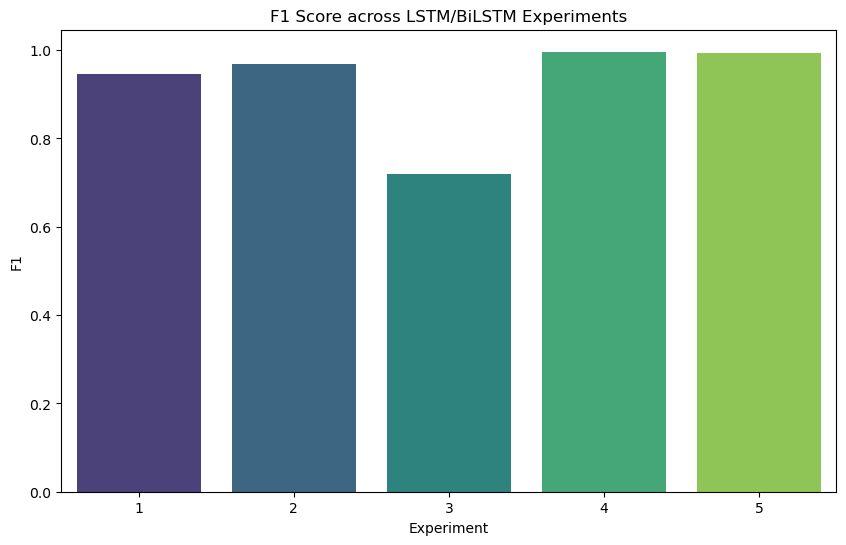

In [6]:
results_df = pd.DataFrame([{k:v for k,v in r.items() if not k.startswith("_")} for r in results])
print(results_df.sort_values("F1", ascending=False))

plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Experiment", y="F1", palette="viridis")
plt.title("F1 Score across LSTM/BiLSTM Experiments")
plt.show()


In [8]:
import os, json
os.makedirs("../models/final", exist_ok=True)

# Find best F1
best_idx = results_df["F1"].idxmax()
best = results[best_idx]
print("🎉 Best experiment:", best["Experiment"], "| F1 =", best["F1"])

# Save model
best_model = best["_model_obj"]
# Save in TF SavedModel format (recommended for Streamlit apps)
best_path = "../models/final/best_lstm_bilstm.keras"
best_model.save(best_path)


# Save metadata (so inference knows how to preprocess)
meta = {
    "experiment": best["Experiment"],
    "params": best["Params"],
    "model_path": best_path,
    "preprocessing": {"tokenizer": "../models/tokenizer.pkl", "max_len": MAX_LEN}
}

with open("../models/final/metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Best model + metadata saved in ../models/final/")

🎉 Best experiment: 4 | F1 = 0.9963837481386939
✅ Best model + metadata saved in ../models/final/
